In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## NN, Downsample train, NAICS only embedding
Do the embedding model again but downsample training.  This is a baseline for comparing random vs. the custom data generator

Use the dataset with no missing values. 

*This script takes about 15 minutes on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model

## Input Data, Downsample Train

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [7]:
train_samp, _ = train_test_split(sba_loans[sba_loans['dset'] == 'train'].index,
                                train_size=0.10,
                                random_state=46)
print(train_samp.shape)

(44684,)


In [8]:
sba_loans = pd.concat([sba_loans[sba_loans['dset'] != 'train'],
                sba_loans.loc[train_samp, :]])      

In [9]:
sba_loans.shape

(293336, 55)

In [10]:
sba_loans['dset'].value_counts()

dset
test     153048
val       95604
train     44684
Name: count, dtype: int64

In [11]:
sba_loans.to_parquet(Path(setup.temp_path).joinpath('20_DATA_downsamp_train.parquet'))

In [12]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [13]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)
naics_max_levels

{'NAICS': 1170,
 'NAICS_5': 764,
 'NAICS_4': 345,
 'NAICS_3': 107,
 'NAICS_sector': 21}

##### Features

In [14]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [15]:
# NAICS feature - just bas
features_naics = ['NAICS']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [16]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170]
[8]


##### Datasets for train, validation

In [17]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric].set_index('LoanNr_ChkDgt').sort_index()

In [18]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (44684, 10), y:(44684,)


In [19]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 10), y:(95604,)


In [20]:
base_thresh = y_train.mean()
print(base_thresh)

0.20295855339718916


In [21]:
X_naics = [sba_loans[['dset', 'LoanNr_ChkDgt', n]].set_index('LoanNr_ChkDgt').sort_index() \
           for n in features_naics]

In [22]:
X_naics_train = [Xn[Xn['dset'] == 'train'].drop(columns='dset') for Xn in X_naics]
X_naics_val =  [Xn[Xn['dset'] == 'val'].drop(columns='dset') for Xn in X_naics]

## Create, fit model

In [23]:
this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)

2024-05-20 13:33:22.911595: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-20 13:33:22.911633: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-20 13:33:22.911652: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-20 13:33:22.911691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-20 13:33:22.911708: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
this_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_naics_00 (InputLayer  [(None, 1)]                  0         []                            
 )                                                                                                
                                                                                                  
 emb_naics_00 (Embedding)    (None, 1, 8)                 9360      ['input_naics_00[0][0]']      
                                                                                                  
 NAICS (Flatten)             (None, 8)                    0         ['emb_naics_00[0][0]']        
                                                                                                  
 input_numeric (InputLayer)  [(None, 10)]                 0         []                        

In [25]:
callback = keras.callbacks.EarlyStopping(patience=3)

In [26]:
this_history = this_model.fit([X_train] + X_naics_train, y_train,
                              validation_data=([X_val] + X_naics_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs,
                              callbacks=[callback])

Epoch 1/20


2024-05-20 13:33:23.667974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1397/1397 [==============================] - ETA: 0s - loss: 0.4823 - auc: 0.2923 - auc_1: 0.6557

2024-05-20 13:33:44.651885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1397/1397 [==============================] - 59s 41ms/step - loss: 0.4823 - auc: 0.2923 - auc_1: 0.6557 - val_loss: 0.4691 - val_auc: 0.3425 - val_auc_1: 0.7021
Epoch 2/20
1397/1397 [==============================] - 70s 50ms/step - loss: 0.4644 - auc: 0.3376 - auc_1: 0.6997 - val_loss: 0.4619 - val_auc: 0.3442 - val_auc_1: 0.7043
Epoch 3/20
1397/1397 [==============================] - 72s 51ms/step - loss: 0.4591 - auc: 0.3494 - auc_1: 0.7102 - val_loss: 0.4625 - val_auc: 0.3509 - val_auc_1: 0.7060
Epoch 4/20
1397/1397 [==============================] - 73s 52ms/step - loss: 0.4560 - auc: 0.3553 - auc_1: 0.7161 - val_loss: 0.4610 - val_auc: 0.3509 - val_auc_1: 0.7075
Epoch 5/20
1397/1397 [==============================] - 71s 51ms/step - loss: 0.4544 - auc: 0.3606 - auc_1: 0.7188 - val_loss: 0.4611 - val_auc: 0.3531 - val_auc_1: 0.7079
Epoch 6/20
1397/1397 [==============================] - 73s 53ms/step - loss: 0.4526 - auc: 0.3633 - auc_1: 0.7225 - val_loss: 0.4604 - val_auc: 0.3520

In [27]:
this_history_df = sbnn_model.process_history(this_history)

In [28]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('20_REPORT_fit_history.csv'))

<Axes: >

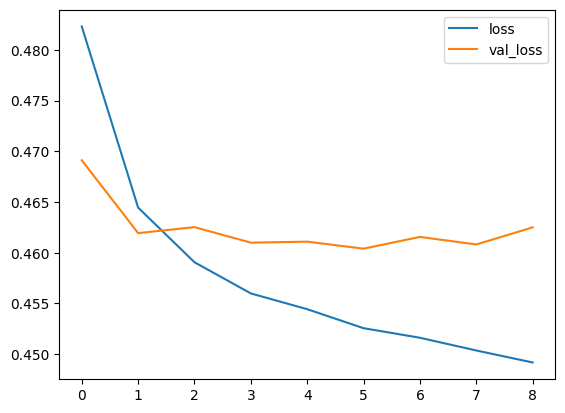

In [29]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

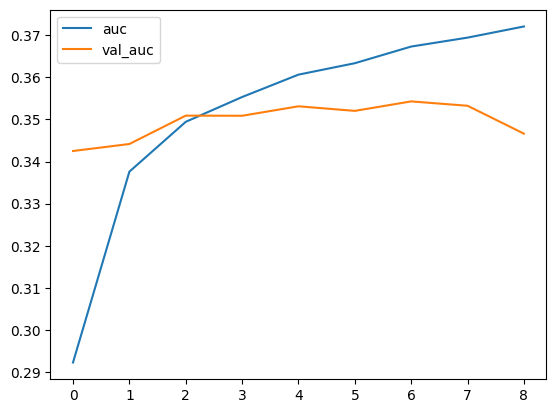

In [30]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

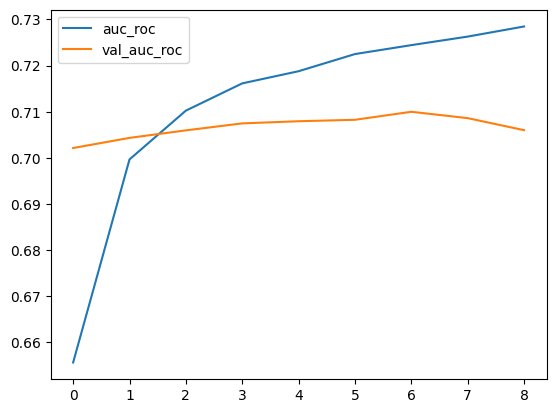

In [31]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [32]:
this_model.save(Path(setup.temp_path).joinpath('20_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [34]:
all_predictions = this_model.predict([X.drop(columns='dset')] +
                                     [Xn.drop(columns='dset') for Xn in X_naics])

  83/9167 [..............................] - ETA: 16s

2024-05-20 13:43:30.771749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9167/9167 [==============================] - 19s 2ms/step


In [35]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
           on='LoanNr_ChkDgt')

In [36]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.288166
target,0.288166,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [37]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [38]:
thresh_tune_data = sbnn_metrics.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [39]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
11,0.22,0.459205
10,0.20,0.456325
12,0.24,0.453697


In [40]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.22

##### Append binary predictions to probability predictions

In [41]:
all_predictions_df['predict_bin'] = sbnn_metrics.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [42]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
0    0.54397
1    0.45603
Name: proportion, dtype: float64

In [43]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('20_DATA_predictions.parquet'))

## Metrics

In [44]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('20_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.601994,0.426119,0.300444,0.732541,0.336807,0.699021,NaN
1,train,0.665652,0.459205,0.341812,0.699416,0.392223,0.740227,NaN
2,val,0.646647,0.431547,0.321049,0.658028,0.346680,0.706018,NaN
0,test,0.647854,0.430453,0.320569,0.654958,0.345469,0.703519,0.0
1,test,0.525769,0.420679,0.278023,0.864013,0.328941,0.706302,1.0
